# Find the best LR in TensorFlow

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)
import numpy as np

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_val, y_val) = mnist.load_data()
X_train, X_val = X_train / 255.0, X_val / 255.0
print(X_train.shape, X_val.shape)
X_train=np.expand_dims(X_train, 3)   #.reshape(-1,28,28,1)
X_val=np.expand_dims(X_val, 3)   #.reshape(-1,28,28,1)
print(X_train.shape, X_val.shape)


(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [3]:
def getModel(opt):
    model = tf.keras.models.Sequential([
                tf.keras.layers.Conv2D(16,(3,3), activation='relu', strides=(2,2), input_shape=(28, 28,1)),
                tf.keras.layers.Conv2D(64,(3,3), activation='relu', strides=(2,2)),
                tf.keras.layers.Conv2D(256,(3,3), activation='relu', strides=(2,2)),
                tf.keras.layers.GlobalAvgPool2D(),
                tf.keras.layers.Dense(10, activation='softmax')])
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [4]:
min_lr=1e-5
max_lr=1e+2
epochs=30
batch_size=128

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: min_lr * 10**((np.log10(max_lr)-np.log10(min_lr)) * epoch / epochs))

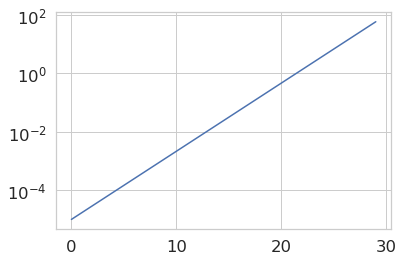

In [18]:
plt.plot([min_lr * 10**((np.log10(max_lr)-np.log10(min_lr)) * epoch / epochs) for epoch in range(30)])
plt.yscale('log')

In [5]:
optimizers=[tf.keras.optimizers.SGD(),
            tf.keras.optimizers.RMSprop(),
            tf.keras.optimizers.Adam(),
            tf.keras.optimizers.Adadelta(),
            tf.keras.optimizers.Adagrad(),
            tf.keras.optimizers.Adamax(),
            tf.keras.optimizers.Nadam(),
            tf.keras.optimizers.Ftrl()]

histories=[]

for opt in optimizers:
    print(opt._name)
    model = getModel(opt)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        verbose=0,
                        callbacks=[lr_schedule],
                        validation_data=(X_val,y_val),)
    histories.append(history)

SGD
RMSprop
Adam
Adadelta
Adagrad
Adamax
Nadam
Ftrl


SGD Best LR: 0.7943282
RMSprop Best LR: 0.010797752
Adam Best LR: 0.010797752
Adadelta Best LR: 11.659144
Adagrad Best LR: 1.3593564
Adamax Best LR: 0.054116953
Nadam Best LR: 0.010797752
Ftrl Best LR: 0.7943282


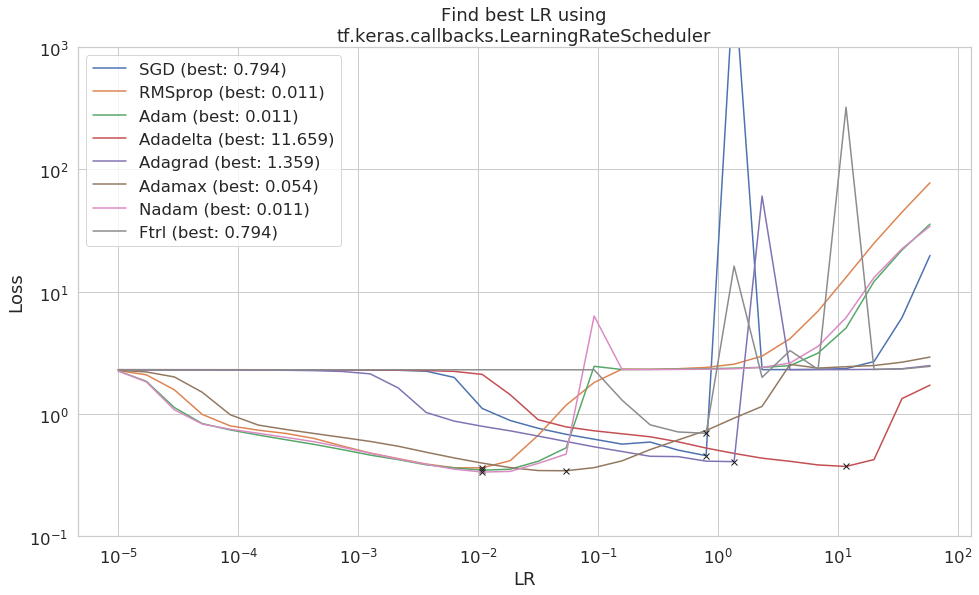

In [6]:
plt.figure(figsize=(16,9))
for opt,history in zip(optimizers,histories):
    name = opt._name
    _min=np.argmin(history.history["loss"])
    print(name+' Best LR:',history.history["lr"][_min])

    plt.semilogx(history.history["lr"], history.history["loss"], label=name+' (best: %.3f)'%history.history["lr"][_min])
    plt.semilogx(history.history["lr"][_min], history.history["loss"][_min],'kx')
    plt.xlabel('LR')
    plt.ylabel('Loss')
    plt.title('Find best LR using\ntf.keras.callbacks.LearningRateScheduler')
    plt.yscale('log')
    plt.legend();
plt.ylim(0.1,1000);

# Find the best LR in PyTorch

In [7]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)
import numpy as np

In [8]:
dataset_root='data'

epochs=100
batch_size=128
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
train_dataset = dset.FashionMNIST(dataset_root,train=True, download=True,transform=transform)
val_dataset = dset.FashionMNIST(dataset_root,train=False,transform=transform)
train_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [9]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 64)
        self.dropout1 = torch.nn.Dropout(0.1)
        self.fc2 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        output = torch.nn.functional.log_softmax(x, dim=1)
        return output

In [10]:
min_lr=1e-5
max_lr=1e+2
epochs=30
steps=(epochs-1)*len(train_loader)
lr_lambda = lambda epoch: min_lr * 10**((np.log10(max_lr)-np.log10(min_lr)) * (epoch) / float(steps))

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

torch_optimizers = [torch.optim.SGD,
                   torch.optim.Adadelta,
                   torch.optim.Adagrad,
                   torch.optim.Adam,
                   torch.optim.AdamW,
                   torch.optim.Adamax,
                   torch.optim.ASGD,
                   torch.optim.RMSprop,
                   torch.optim.Rprop,
                   ]
lrs_losses=[]
for opt in torch_optimizers:
    print(str(opt))
    model = Net().to(device)
    optimizer = opt(model.parameters(),lr=1)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    losses=[]
    lrs=[]

    for epoch in range(1, epochs + 1):
        lr=scheduler.get_last_lr()
        lrs.append(lr[0])
        model.train()
        train_correct=0
        epoch_loss=0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = torch.nn.functional.nll_loss(output, target)
            epoch_loss+=loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

        epoch_loss /= len(train_loader.dataset)
        losses.append(epoch_loss)
#         print('Epoch %d LR %.8f Loss %f'%(epoch, lr[0], epoch_loss))
    lrs_losses.append((lrs,losses))
    del model

<class 'torch.optim.sgd.SGD'>
<class 'torch.optim.adadelta.Adadelta'>
<class 'torch.optim.adagrad.Adagrad'>
<class 'torch.optim.adam.Adam'>
<class 'torch.optim.adamw.AdamW'>
<class 'torch.optim.adamax.Adamax'>
<class 'torch.optim.asgd.ASGD'>
<class 'torch.optim.rmsprop.RMSprop'>
<class 'torch.optim.rprop.Rprop'>


sgd Best LR: 18.87391822135096
adadelta Best LR: 0.22122162910704501
adagrad Best LR: 0.07278953843983155
adam Best LR: 0.007880462815669913
adamw Best LR: 0.004520353656360245
adamax Best LR: 0.004520353656360245
asgd Best LR: 0.07278953843983155
rmsprop Best LR: 0.0014873521072935117
rprop Best LR: 1e-05


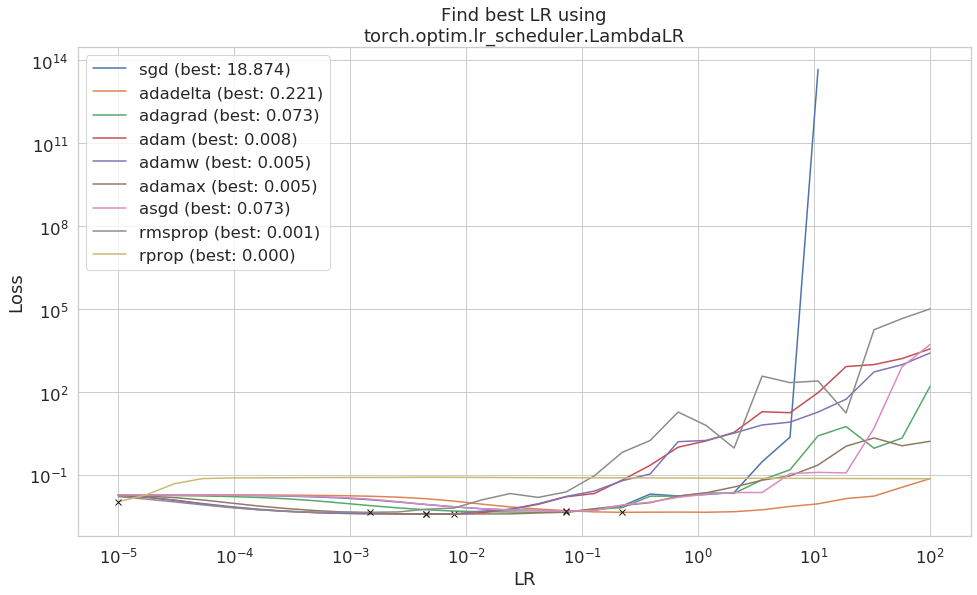

In [12]:
plt.figure(figsize=(16,9))

for opt, (lrs, losses) in zip(torch_optimizers,lrs_losses):
    name = str(opt.__module__).split('.')[-1]
    _min=np.argmin(losses)
    print(name,'Best LR:',lrs[_min])

    plt.semilogx(lrs,losses, label=name+' (best: %.3f)'%lrs[_min])
    plt.semilogx(lrs[_min], losses[_min], 'kx')
    plt.xlabel('LR')
    plt.ylabel('Loss')
    plt.title('Find best LR using\ntorch.optim.lr_scheduler.LambdaLR')
    plt.yscale('log')
    plt.legend();